In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from scipy.stats import gaussian_kde

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
%matplotlib inline

In [2]:
df = pd.read_csv('Real Scripts/final.csv')

/Library/Python/2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
df.columns

Index([u'date', u'hour', u'terminal', u'Date', u'Max_Temperature_F',
       u'Mean_Temperature_F', u'Min_TemperatureF', u'Max_Dew_Point_F',
       u'MeanDew_Point_F', u'Min_Dewpoint_F', u'Max_Humidity',
       u'Mean_Humidity ', u'Min_Humidity ', u'Max_Sea_Level_Pressure_In ',
       u'Mean_Sea_Level_Pressure_In ', u'Min_Sea_Level_Pressure_In ',
       u'Max_Visibility_Miles ', u'Mean_Visibility_Miles ',
       u'Min_Visibility_Miles ', u'Max_Wind_Speed_MPH ',
       u'Mean_Wind_Speed_MPH ', u'Max_Gust_Speed_MPH', u'Precipitation_In ',
       u'Events', u'count', u'name', u'lat', u'long', u'dockcount', u'online',
       u'elevation', u'hood', u'big_cluster', u'smallgroups'],
      dtype='object')

In [4]:
# Clean mac gust speed column


df.ix[df['Max_Gust_Speed_MPH'] == '-', 'Max_Gust_Speed_MPH'] = np.nan
df['Max_Gust_Speed_MPH'] = df['Max_Gust_Speed_MPH'].astype(float)
df['Max_Gust_Speed_MPH'] = df['Max_Gust_Speed_MPH'].fillna(df['Max_Gust_Speed_MPH'].mean())

In [5]:
new_terminals = df.ix[df['online'] != '10/13/2014','terminal'].unique()
print new_terminals

['CBD-04' 'CD-01' 'SLU-20' 'SLU-21']


In [6]:
online = []
for t in new_terminals:
    online.append(df.ix[df['terminal'] == t,'online'].unique()[0])
online

['7/22/2015', '5/21/2015', '6/12/2015', '9/19/2015']

In [7]:
smallgroups = []
for t in new_terminals:
    smallgroups.append(df.ix[df['terminal'] == t,'smallgroups'].unique()[0])
print smallgroups 


[8, 0, 8, 6]


473040

In [8]:
df['date'] = pd.to_datetime(df['date'])

In [9]:
df['timeperiod'] = pd.cut(df['hour'].astype(int),[-.01,7,10,15,18,21])

In [10]:
df['dayofweek'] = df['date'].map(lambda x: x.dayofweek)
df['month'] = df['date'].map(lambda x: x.month)
df['season'] = df['date'].map(lambda x: x.quarter)
df['year'] = df['date'].map(lambda x: x.year)


In [11]:
df_final = df.ix[~df['terminal'].isin(new_terminals),~df.columns.isin(['lat','long','online','date','Date','name','hood'])]

In [169]:
df_final.to_csv('regression.csv', index = False)

In [12]:
from sklearn.ensemble import RandomForestRegressor as RFC
from sklearn.cross_validation import train_test_split

In [13]:
dff = df_final.ix[:,~df_final.columns.isin(['Max_Wind_Speed_MPH','Mean_Visibility_Miles','Min_Humidity','Mean_Temperature_F','Max_Temperature_F','Mean_Visibility_Mile','Min_Visibility_Miles','elevation','dockcount','timeperiod','season','Max_Visibility_Miles','big_cluster','smallgroups'])]

In [24]:
df_rf = pd.get_dummies(dff, columns = ['hour','dayofweek','year','terminal','month','Events'])

In [25]:
y = df_rf['count']
X = df_rf.ix[:,~df_rf.columns.isin(['count'])].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [29]:
rf = RFC(n_estimators=200, verbose = True, n_jobs = -1)

In [30]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   1 out of 200 | elapsed:  1.1min remaining: 211.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 48.7min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=True, warm_start=False)

In [32]:
score =  rf.score( X_test, y_test)

[Parallel(n_jobs=4)]: Done   1 out of 200 | elapsed:    0.1s remaining:   14.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.9s finished


In [62]:
sum((rf.predict(X_test) - y_test)**2)/len(y_test)

[Parallel(n_jobs=4)]: Done   1 out of 200 | elapsed:    0.1s remaining:   14.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.8s finished


0.52665339269405576

In [39]:
preds = rf.predict(X_test)

[Parallel(n_jobs=4)]: Done   1 out of 200 | elapsed:    0.1s remaining:   12.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


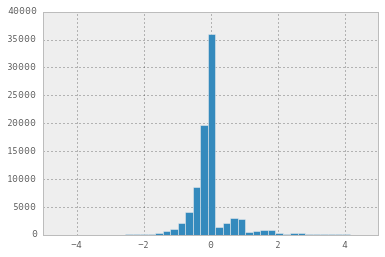

In [60]:
fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_xlim([-5,5])
plt.hist((y_test-preds).values, bins = 100)

plt.show()

In [22]:
#large = dff.ix[dff['count'] > 10, :]

In [23]:
#large.groupby(['terminal'])['count'].count()

terminal
BT-01      4
BT-03      2
CBD-03     4
CBD-06     1
CBD-07     1
CBD-13     1
CH-02      1
CH-08      1
PS-04      5
SLU-01     1
SLU-04     2
SLU-15     1
SLU-16     1
SLU-17     4
SLU-18     1
UD-04      1
WF-01     24
WF-04      3
Name: count, dtype: int64

In [236]:
df_rf['count'].value_counts()

0     353065
1      52221
2      20089
3       7185
4       3003
5       1273
6        612
7        239
8        135
9         67
10        53
11        23
12        13
13        11
17         3
14         2
18         2
19         1
15         1
16         1
44         1
dtype: int64

In [ ]:
z = rf.predict(X_train)

In [ ]:
pd.Series(z).value_counts()

In [64]:
dff.to_csv('final_demand.csv', index = False)